In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time
import copy
import pickle
from tqdm.auto import trange

import numpy as np
import numpy.random as npr
from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from scipy.ndimage import gaussian_filter1d

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
from matplotlib.patches import Rectangle
from matplotlib.cm import jet
from matplotlib.gridspec import GridSpec

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from ssm import HMM
from ssm.util import rle
from ssm.primitives import hmm_sample, lds_sample
from ssm.observations import GaussianObservations
from ssm.init_state_distns import InitialStateDistribution
from ssm.preprocessing import trend_filter, pca_with_imputation

In [3]:
sys.path.insert(0, '..')
import ssm_harness as harness
from ssm_harness import cached

In [4]:
npr.seed(0)
sns.set_style("white")
sns.set_context("talk")

# Load the data

In [5]:
with open("ae_latents.pkl", "rb") as f:
    data = pickle.load(f)
    
latents = data['latents'].astype(np.float64)
T_total, D = latents.shape

# Extract the segments of training data
def extract_segments(latents, indices):
    values, durations = rle(indices)
    offsets = np.concatenate(([0], np.cumsum(durations)[:-1]))
    segments = [latents[offset:offset+duration] 
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    new_indices = [np.arange(offset,offset+duration)
                for value, offset, duration in zip(values, offsets, durations)
                if value == True]
    return segments, new_indices

training_data, train_indices = extract_segments(latents, data['indxs']['train'])
validation_data, validation_indices = extract_segments(latents, data['indxs']['validation'])
test_data, test_indices = extract_segments(latents, data['indxs']['test'])
all_training_data = np.concatenate(training_data, axis=0)

T_train = sum([len(x) for x in training_data])
T_val = sum([len(x) for x in validation_data])
T_test = sum([len(x) for x in test_data])

In [6]:
# Load the neural data
neural_data = np.load("np_spikes.npy").astype(float)
num_neurons = neural_data.shape[1]

In [7]:
# Load the VAE
import tensorflow as tf
from nntools.models import Model

vae_file = 'model_file.pkl'
vae = Model.load_model(vae_file)
vae._check_graph(None, None)

# Load the VAE weights
sess = tf.Session(graph=vae.graph, config=vae.sess_config)
checkpoint_file = 'epoch_00999.ckpt'
vae.restore_model(sess, checkpoint_file=checkpoint_file)



/Users/scott/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


model loaded from model_file.pkl
trainer: adam
data pipeline: feed_dict
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from epoch_00999.ckpt


In [8]:
def decode(trajectory):
    """
    Decode a trajectory of continuous latent states
    """
    # restore model weights from checkpoint file
    # vae.restore_model(sess, checkpoint_file=checkpoint_file)

    # populate feed_dict with latent data
    feed_dict = {vae.network.input_phs[0]: trajectory}

    # populate feed_dict with dropout rates of 1.0 (no dropout)
    for key, value in vae.network.feed_dict.items():
        feed_dict[key] = value

    # push images through network to get reconstructions
    simulated_recon = sess.run(vae.network.layer_outputs[-1], feed_dict=feed_dict)
        
    return simulated_recon


# Preprocess the neural data with smoothing and PCA

In [9]:
# _preprocess_neural_data = cached(".", "preprocessed_neural_data")(harness.preprocess_neural_data)
_preprocess_neural_data = harness.preprocess_neural_data
normalized_rates, lowd_neural_data, pca = _preprocess_neural_data(neural_data, num_components=25, fs=25, window=0.1)

Text(0.5, 0, 'PC')

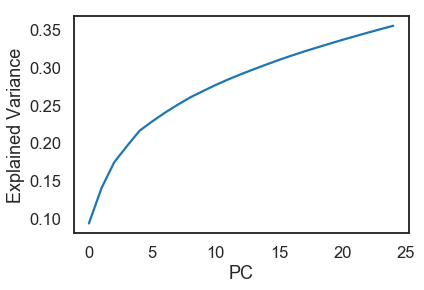

In [10]:
# Do some dimensionality reduction on the neural data
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.ylabel("Explained Variance")
plt.xlabel("PC")

In [11]:
# Choose the number of PCs to use
M = 25
training_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['train'])
validation_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['validation'])
test_inputs, _ = extract_segments(lowd_neural_data[:, :M], data['indxs']['test'])

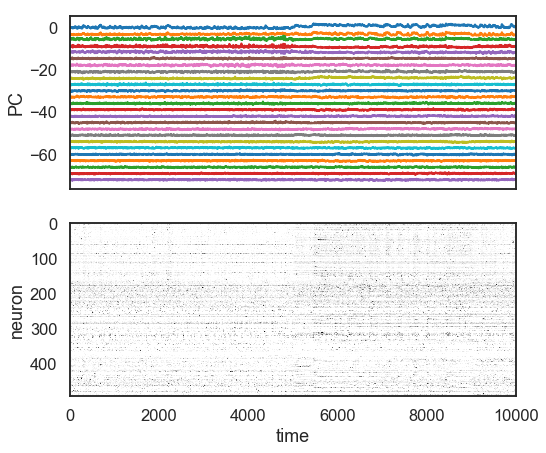

In [12]:
fig = harness.plot_neural_activity(lowd_neural_data, normalized_rates)
fig.savefig("neural_data.png", dpi=300)

# Train a linear decoder to predict VAE latents directly

In [13]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
all_xtrain = np.concatenate(training_data, axis=0)
all_utrain = np.concatenate(training_inputs, axis=0)
lr.fit(np.concatenate(training_inputs, axis=0), np.concatenate(training_data, axis=0))
lr_xtrain = lr.predict(all_utrain)
lr.Sigma_ = np.cov((lr_xtrain - all_xtrain).T)

lr_xtest = [lr.predict(test_input) for test_input in test_inputs]

No handles with labels found to put in legend.


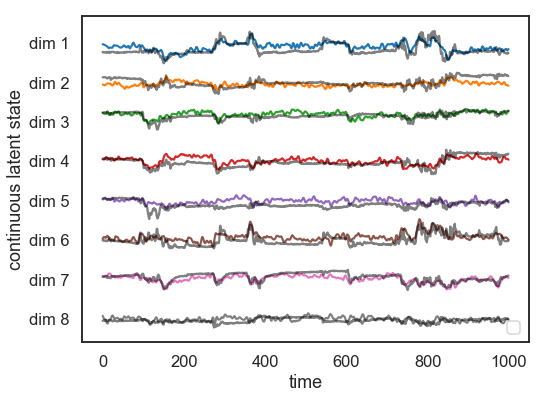

In [14]:
test_idx = 2
fig = harness.plot_sampled_latents(test_data[test_idx], [lr_xtest[test_idx]], lw=2)
fig.savefig("./lr_xpreds.png", dpi=300)

# Fit ARHMM's to the behavioral data

In [24]:
# Fit a sticky tARHMM

num_discrete_states = np.arange(8, 9)

std_models = dict(
    
    arhmm=dict(transitions="standard", 
               observations="ar"),
    
)

input_models = dict(
    
#     input_arhmm_zonly=dict(transitions="inputdriven", 
#                            transition_kwargs=dict(l2_penalty=0.0), 
#                            observations="no_input_ar"),
    
    input_arhmm=dict(transitions="inputdriven", 
                     transition_kwargs=dict(l2_penalty=0.0), 
                     observations="ar", 
                     observation_kwargs=dict(l2_penalty_V=0.0)),
    
#     tarhmm=dict(transitions="standard", observations="robust_ar"),
#     hmm=dict(transitions="standard", observations="gaussian"),
#     input_hmm=dict(transitions="inputdriven", transition_kwargs=dict(l2_penalty=0.0), observations="gaussian"),
#     input_tarhmm=dict(transitions="inputdriven", transition_kwargs=dict(l2_penalty=0.0), 
#                       observations="robust_ar", observation_kwargs=dict(l2_penalty_V=0.0)),
#     sticky_arhmm=dict(transitions="sticky", transition_kwargs=dict(kappa=100), observations="ar"),
#     sticky_tarhmm=dict(transitions="sticky", transition_kwargs=dict(kappa=100), observations="robust_ar"),
#     recurrent_arhmm=dict(transitions="recurrent", observations="ar"),
)

all_results = dict()

for model_name, kwargs in std_models.items():
    model_results = dict()
    for K in num_discrete_states:
        print("Fitting", model_name, "with", K, "states.")
        file_name = "{}_K{}.pkl".format(model_name, K)
        # _fit = cached(".", file_name)(harness.fit_model)
        _fit = harness.fit_model
        model_results[K] = _fit(K, D, 0, kwargs, 
                                training_data, validation_data, test_data)
        
    all_results[model_name] = model_results
    
for model_name, kwargs in input_models.items():
    model_results = dict()
    for K in num_discrete_states:
        print("Fitting", model_name, "with", K, "states.")
        file_name = "{}_K{}.pkl".format(model_name, K)
        # _fit = cached(".", file_name)(harness.fit_model)
        _fit = harness.fit_model
        model_results[K] = _fit(K, D, M, kwargs, 
                                training_data, validation_data, test_data, 
                                training_inputs, validation_inputs, test_inputs)
        
    all_results[model_name] = model_results

Fitting arhmm with 8 states.



Fitting input_arhmm with 8 states.


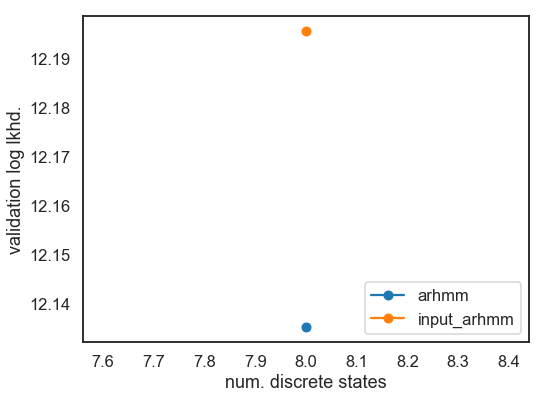

In [25]:
line_styles = dict(
    arhmm='-',
    input_arhmm='-',
    input_arhmm_zonly='-',
)

fig = harness.plot_validation_likelihoods(all_results, line_styles=line_styles, T_val=T_val)
fig.savefig("validation_likelihoods.png", dpi=300)

In [27]:
# Select the number of discrete states with the cross validated log likelihood
best_results = dict()
for model_name, model_results in all_results.items():
    val_lls = np.array([model_results[K]['val_ll'] for K in num_discrete_states])
    best_num_states = num_discrete_states[np.argmax(val_lls)]
    best_results[model_name] = model_results[best_num_states]

# Sample from the ARHMMs conditioned on neural data

In [28]:
test_idx = 0
T_smpl = test_inputs[test_idx].shape[0]

for model_name, model_results in best_results.items():
    print("Sampling ", model_name)
    model = model_results["model"]
    inputs = test_inputs[test_idx] if model.M > 0 else np.zeros((T_smpl, 0))
    
#     _sample = cached(".", "{}_test{}_smpls".format(model_name, test_idx))(harness.sample_arhmm)
    _sample = harness.sample_arhmm
    model_results["z_smpls"], model_results["x_smpls"] = _sample(model, inputs, with_noise=False, num_samples=100)

Sampling  arhmm



Sampling  input_arhmm


# Make some plots

In [29]:
best_results["arhmm"]["model"].K

8

No handles with labels found to put in legend.


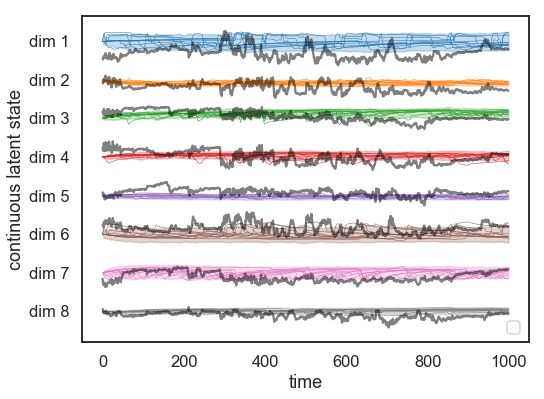

In [30]:
fig = harness.plot_sampled_latents(test_data[test_idx], best_results["arhmm"]["x_smpls"])
fig.savefig("./arhmm_xsmpls.png", dpi=300)

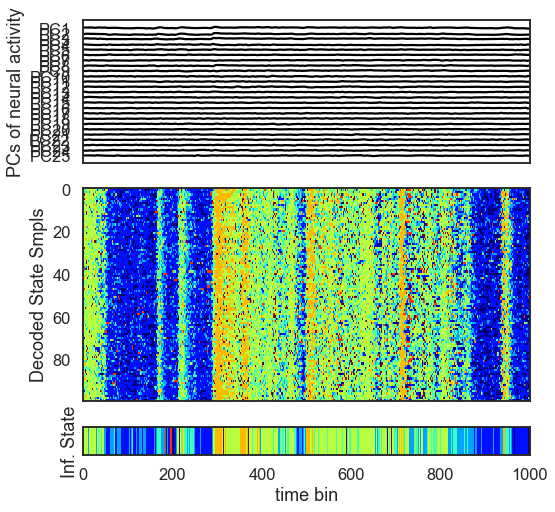

In [31]:
z_inf = best_results["input_arhmm"]["model"].most_likely_states(test_data[test_idx], 
                                                                input=test_inputs[test_idx])

fig = harness.plot_neural_and_discrete_samples(
    test_inputs[test_idx], 
    best_results["input_arhmm"]["z_smpls"],
    z_inf)

fig.savefig("./input_arhmm_zsmpls.png", dpi=300)

# Try a different approach, more like a CRF
Fit an SLDS where x=behavioral states and y=neural data.  Then run posterior inference to infer behavioral states of new neural data. 

In [127]:
# # Initialize the SLDS emissions to match the LR decoder
# # Invert the model p(x | u) = N(x | Wu + b, Sigma) to estimate p(u | x) under Gaussian prior on u
# # Map this to linear emissions p(u | x) = N(u | Cx + d, S)
# W, b = lr.coef_, lr.intercept_
# all_utrain = np.concatenate(training_inputs, axis=0)
# all_xtrain = np.concatenate(training_data, axis=0)
# xhats = lr.predict(all_utrain)
# Sigma_x = np.cov((xhats - all_xtrain).T)
# mu_u = np.mean(all_utrain, axis=0)
# Sigma_u =  np.cov(all_utrain.T)

# Sinv = np.linalg.inv(Sigma_u) + W.T.dot(np.linalg.solve(Sigma_x, W))
# S = np.linalg.inv(Sinv)
# C = S.dot(np.linalg.solve(Sigma_x, W).T)
# d = S.dot(np.linalg.solve(Sigma_u, mu_u) - np.linalg.solve(Sigma_x, W).T.dot(b))

In [224]:
# Fit with another LDS.  Give it twice as many states in
# order to have some flexibility during inference.
from pyslds.models import DefaultSLDS
K = 8
D_obs = M
D_latent = D
D_input = 1

mu_init = np.concatenate(training_data, axis=0).mean(axis=0)
sigma_init = np.cov(np.concatenate(training_data, axis=0).T)

# slds = DefaultSLDS(K, D_obs, D_latent, D_input,
#                    Cs=C, Ds=d[:, None], sigma_obss=Sinv)
slds = DefaultSLDS(K, D_obs, D_latent, D_input,
                   mu_inits=[mu_init] * K,
                   sigma_inits=[sigma_init] * K)

for x, y in zip(training_data, training_inputs):
    T = x.shape[0]
    z = npr.randint(K, size=T)
    bias = np.ones((T, 1))
    slds.add_data(y, inputs=bias, stateseq=z, gaussian_states=x)

In [225]:
# Initialize with Gibbs sampler
print("Fitting with Gibbs")
N_gibbs_samples = 300
def step(model):
    # model.resample_parameters()
    
    # resample parameters except for emissions model
    # model.resample_init_dynamics_distns()
    model.resample_dynamics_distns()
    model.resample_emission_distns()
    model.resample_hmm_parameters()
    
    for states in model.states_list:
        # Skip the continuous state samples
        states.resample_discrete_states()
    
    return model.log_likelihood()

gibbs_lls = [step(slds) for _ in trange(N_gibbs_samples)]

Fitting with Gibbs


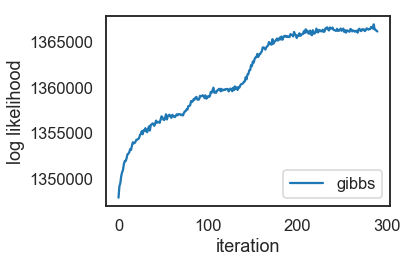

In [227]:
# Plot the log likelihoods
plt.figure()
plt.plot(gibbs_lls[10:], label="gibbs")
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend(loc="lower right")
plt.tight_layout()

# Try fixing the emission potentials to the same as the linear regression

In [60]:
from pyslds.models import HMMSLDS, _default_model
from pyslds.states import HMMSLDSStatesEigen

class LinRegEmissionSLDSStates(HMMSLDSStatesEigen):
    """
    Override the info form emission params with those of a linear regression
    """
    def __init__(self, model, covariates=None, scale=1.0, **kwargs):
        super(LinRegEmissionSLDSStates, self).__init__(model, **kwargs)
        
        # Precompute the info form potentials from the linear regression
        assert np.isscalar(scale)
        assert covariates.shape[0] == self.data.shape[0]
        self.J_node = scale * np.linalg.inv(self.lr_Sigma) * np.ones((self.T, self.D_latent, self.D_latent))
        self.h_node = scale * np.linalg.solve(self.lr_Sigma, (covariates.dot(self.lr_W.T) + self.lr_b).T).T
        self.log_Z_node = np.zeros(self.T)
        
    @property
    def lr_W(self):
        return self.model.lr.coef_
        
    @property
    def lr_b(self):
        return self.model.lr.intercept_
    
    @property
    def lr_Sigma(self):
        return self.model.lr.Sigma_
    
    @property
    def info_emission_params(self):
        return self.J_node, self.h_node, self.log_Z_node
    

class LinRegEmissionSLDS(HMMSLDS):
    _states_class = LinRegEmissionSLDSStates
    
    def __init__(self, dynamics_distns,
                       emission_distns,
                       init_dynamics_distns,
                       lr=None,
                       **kwargs):
        super(LinRegEmissionSLDS, self).__init__(
            dynamics_distns, 
            emission_distns, 
            init_dynamics_distns, 
            **kwargs)
        
        assert isinstance(lr, LinearRegression)
        self.lr = lr
    
#     def resample_emission_distns(self):
#         pass
    
    
def DefaultLinRegSLDS(K, D_obs, D_latent, D_input=0,
                mu_inits=None, sigma_inits=None,
                As=None, Bs=None, sigma_statess=None,
                Cs=None, Ds=None, sigma_obss=None,
                alpha=3.,
                **kwargs):
    return _default_model(LinRegEmissionSLDS, K, D_obs, D_latent, D_input=D_input,
                          mu_inits=mu_inits, sigma_inits=sigma_inits,
                          As=As, Bs=Bs, sigma_statess=sigma_statess,
                          Cs=Cs, Ds=Ds, sigma_obss=sigma_obss,
                          alpha=alpha,
                          **kwargs)

In [63]:
# Fit with another LDS.  Give it twice as many states in
# order to have some flexibility during inference.
from pyslds.models import DefaultSLDS
K = 8
D_obs = M
D_latent = D
D_input = 1

mu_init = np.concatenate(training_data, axis=0).mean(axis=0)
sigma_init = np.cov(np.concatenate(training_data, axis=0).T)

slds = DefaultLinRegSLDS(K, D_obs, D_latent, D_input,
                         mu_inits=[mu_init] * K,
                         sigma_inits=[sigma_init] * K,
#                          Cs=npr.randn(D_obs, D_latent), 
#                          Ds=npr.randn(D_obs, 1),
                         lr=lr)

for x, y in zip(training_data, training_inputs):
    T = x.shape[0]
    z = npr.randint(K, size=T)
    bias = np.ones((T, 1))
    slds.add_data(y, inputs=bias, stateseq=z, gaussian_states=x, covariates=y, scale=1)

In [64]:
# Initialize with Gibbs sampler
print("Fitting with Gibbs")
N_gibbs_samples = 300
def step(model):
    # model.resample_parameters()
    
    # resample parameters except for emissions model
    # model.resample_init_dynamics_distns()
    model.resample_dynamics_distns()
    model.resample_emission_distns()
    model.resample_hmm_parameters()
    
    for states in model.states_list:
        # Skip the continuous state samples
        states.resample_discrete_states()
    
    return model.log_likelihood()

gibbs_lls = [step(slds) for _ in trange(N_gibbs_samples)]

Fitting with Gibbs


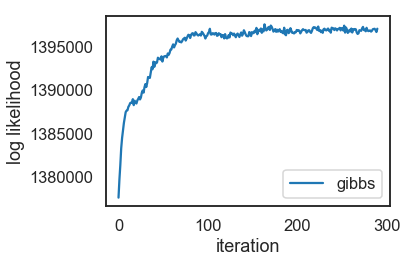

In [65]:
# Plot the log likelihoods
plt.figure()
plt.plot(gibbs_lls[10:], label="gibbs")
plt.xlabel('iteration')
plt.ylabel('log likelihood')
plt.legend(loc="lower right")
plt.tight_layout()

# Decode test data with the SLDS

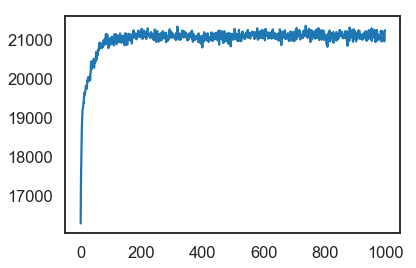

In [79]:
test_idx = 2
T_smpl = test_inputs[test_idx].shape[0]
slds.add_data(test_inputs[test_idx], inputs=np.ones((T_smpl, 1)), 
              covariates=test_inputs[test_idx], scale=1)
states = slds.states_list.pop()

z_smpls = []
x_smpls = []
ll_smpls = []
for itr in trange(1000):
    states.resample()
    z_smpls.append(states.stateseq.copy())
    x_smpls.append(states.gaussian_states.copy())
    ll_smpls.append(states.log_likelihood())

plt.plot(ll_smpls[1:])

No handles with labels found to put in legend.


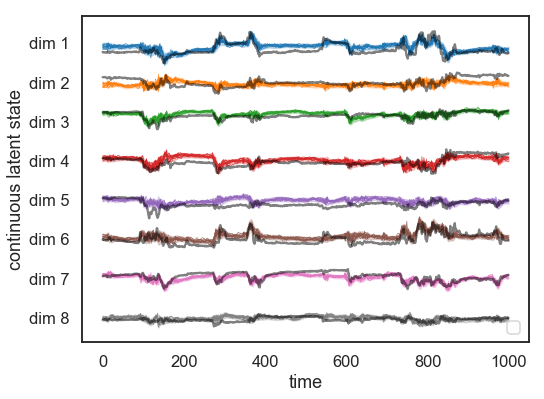

In [84]:
fig = harness.plot_sampled_latents(test_data[test_idx], x_smpls[-500:])
fig.savefig("./bayesian_decoder.png", dpi=300)

No handles with labels found to put in legend.


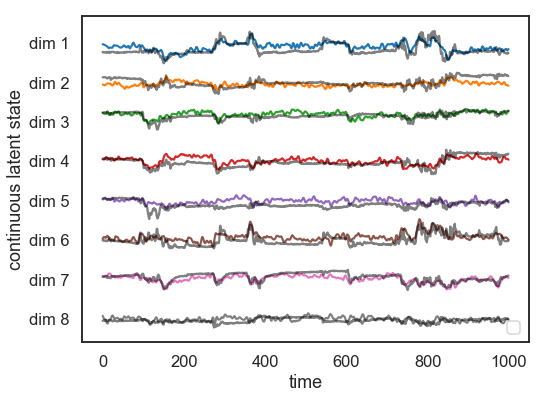

In [85]:
fig = harness.plot_sampled_latents(test_data[test_idx], [lr.predict(test_inputs[test_idx])], lw=2)
fig.savefig("./linear_decoder.png", dpi=300)

const:   0.517
linreg:  0.277
bayes:   0.25


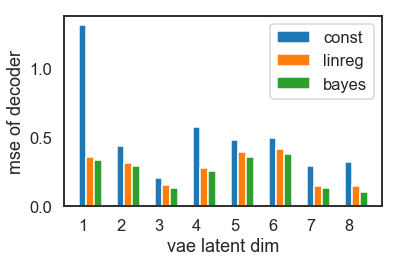

In [90]:
# Compare MSE of Bayesian mean vs linear decoder
mse_const = np.mean((test_data[test_idx] - np.concatenate(training_data).mean(0))**2, axis=0)
mse_lr = np.mean((test_data[test_idx] - lr.predict(test_inputs[test_idx]))**2, axis=0)
mse_bayes = np.mean((test_data[test_idx] - np.mean(x_smpls[-500:], axis=0))**2, axis=0)

plt.bar(np.arange(D), mse_const, width=.2, label="const")
plt.bar(np.arange(D)+.2, mse_lr, width=.2, label="linreg")
plt.bar(np.arange(D)+.4, mse_bayes, width=.2, label="bayes")
plt.xticks(np.arange(D), np.arange(D) + 1)
plt.xlabel("vae latent dim")
plt.ylabel("mse of decoder")
plt.legend(loc="upper right")

plt.tight_layout()

print("const:  ", np.mean(mse_const).round(3))
print("linreg: ", np.mean(mse_lr).round(3))
print("bayes:  ", np.mean(mse_bayes).round(3))

plt.savefig("./mse_decoder.png", dpi=300)

In [97]:
print("Decoding SLDS posterior samples")
decoded_samples = decode(np.mean(x_smpls[-500:], axis=0))
decoded_states = z_smpls[-1]

Decoding SLDS posterior samples


In [96]:
print("Decoding linear regression predictions")
decoded_lr = decode(lr.predict(test_inputs[test_idx]))
decoded_lr_states = np.zeros(T_smpl, dtype=int)

Decoding linear regression predictions


In [92]:
print("Decoding the real data")
decoded_latents = decode(test_data[test_idx])

Decoding the real data


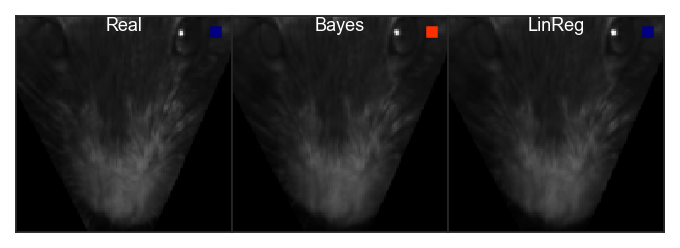

In [100]:
harness.make_hollywood_movie(slds.num_states,
                             decoded_latents, 
                             np.zeros(T_smpl), 
                             [decoded_samples, decoded_lr],
                             [decoded_states, decoded_lr_states],
                             titles=["Real", "Bayes", "LinReg"])

(array([1.1138828e+07, 2.7164580e+06, 1.2141050e+06, 6.0403400e+05,
        3.1813500e+05, 1.7363200e+05, 9.5367000e+04, 5.2407000e+04,
        2.9791000e+04, 1.5700000e+04, 8.2340000e+03, 3.9710000e+03,
        2.1870000e+03, 1.4190000e+03, 9.4300000e+02, 6.7100000e+02,
        4.9900000e+02, 4.1600000e+02, 3.4200000e+02, 3.3500000e+02,
        3.3700000e+02, 2.6700000e+02, 2.7000000e+02, 2.1800000e+02,
        2.0900000e+02, 2.4600000e+02, 2.3300000e+02, 1.9900000e+02,
        1.8600000e+02, 2.0300000e+02, 1.9400000e+02, 1.7900000e+02,
        1.6100000e+02, 1.7200000e+02, 1.5700000e+02, 1.6800000e+02,
        1.8600000e+02, 1.5700000e+02, 1.4500000e+02, 1.2500000e+02,
        1.2100000e+02, 1.0600000e+02, 1.0400000e+02, 1.0400000e+02,
        9.4000000e+01, 8.1000000e+01, 8.7000000e+01, 7.2000000e+01,
        8.0000000e+01, 9.2000000e+01, 7.4000000e+01, 6.4000000e+01,
        7.2000000e+01, 5.2000000e+01, 7.7000000e+01, 5.3000000e+01,
        4.1000000e+01, 4.4000000e+01, 5.5000000e

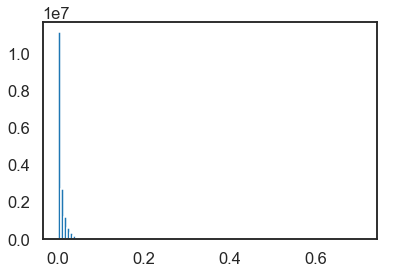

In [113]:
plt.hist(np.ravel(abs(decoded_samples - decoded_latents)), 100)

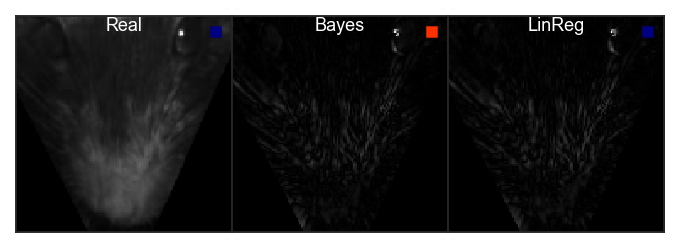

In [118]:
harness.make_hollywood_movie(slds.num_states,
                             decoded_latents, 
                             np.zeros(T_smpl), 
                             [abs(decoded_samples - decoded_latents), abs(decoded_lr - decoded_latents)],
                             [decoded_states, decoded_lr_states],
                             titles=["Real", "Bayes", "LinReg"],
                             same_vlim=False,
                             filename="hollywood_diff.mp4")

# Decode the samples with the VAE

In [47]:
print("Decoding the real data")
decoded_latents = decode(test_data[test_idx])

Decoding the real data


In [24]:
print("Decoding ARHMM samples")
decoded_samples = [decode(best_results["input_arhmm"]["x_smpls"][i]) for i in trange(4)]

Decoding ARHMM samples


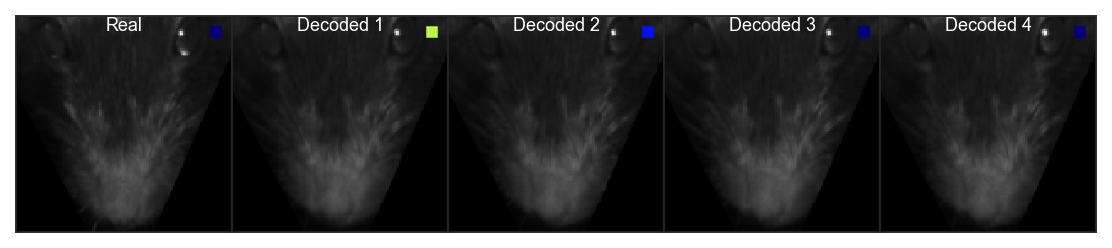

In [25]:
harness.make_hollywood_movie(best_results["input_arhmm"]["model"].K,
                             decoded_latents, 
                             z_inf, 
                             decoded_samples, 
                             best_results["input_arhmm"]["z_smpls"][:4])

# Look into ARHMM input weights

[[ 0.97 -0.01 -0.01 -0.01 -0.01 -0.   -0.01  0.  ]
 [-0.01  0.96  0.   -0.01 -0.   -0.   -0.01 -0.  ]
 [-0.03  0.    0.94 -0.03 -0.02  0.01 -0.01 -0.01]
 [-0.02 -0.   -0.02  0.96  0.    0.   -0.02 -0.01]
 [-0.01 -0.   -0.01 -0.01  0.97  0.01 -0.01 -0.  ]
 [-0.   -0.01  0.01  0.    0.01  0.97  0.01 -0.  ]
 [-0.01  0.01 -0.02 -0.02 -0.01  0.01  0.93 -0.02]
 [ 0.01 -0.   -0.    0.01  0.   -0.   -0.01  0.98]]
[ 0.01405285 -0.00741541  0.05670406  0.04204109  0.01707423 -0.02100308
  0.04802915  0.00514758]


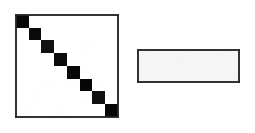

In [67]:
model = best_results["input_arhmm"]["model"]

plt.figure(figsize=(4, 10))
for k in range(model.K):
    plt.subplot(model.K, 2, k * 2 + 1)
    plt.imshow(model.observations.As[k], vmin=0, vmax=1, cmap="Greys")
    print(model.observations.As[k].round(2))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(model.K, 2, k * 2 + 2)
    plt.imshow(model.observations.Vs[k], vmin=-2, vmax=2, cmap="RdBu")
    plt.xticks([])
    plt.yticks([])
    
    print(model.observations.bs[k])

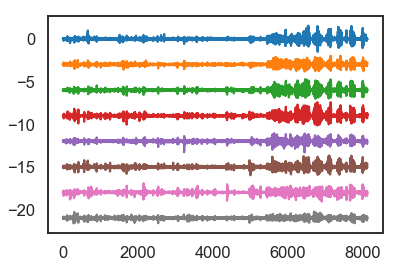

In [68]:
plt.plot(np.diff(training_data[0], axis=0) - 3 * np.arange(8))